Import libraries

In [60]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import graphviz

from timeit import default_timer as timer
from datetime import timedelta

from xgboost import XGBClassifier, plot_tree, to_graphviz
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, recall_score, ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import cross_val_score, KFold


from sklearn.tree import export_graphviz
from holoviews.ipython import display

Train data (longer)

In [61]:
path = "../12CPU_30RAM/43200s/allGroup/merged.csv"
df = pd.read_csv(path).dropna(inplace=False)

df = df.iloc[:,1:]

#single merge file (not grouped)
#df = df.iloc[:,2:]

#methods.csv
if "methods" in path:
    endpoint_map = {
        'do-register': 0,
        'add-sell-offer': 1,
        'add-buy-offer': 2,
        'get-stock-data': 3,
        'add-company': 4,
        'get-stock-users-and-companies': 5

    }
    # zastosowanie mapowania na kolumnę endpointUrl
    df['endpointUrl'] = df['endpointUrl'].replace(endpoint_map)

#
if 'replicaId' in df.columns:
    df['replicaId'] = pd.factorize(df['replicaId'])[0]


# zaokrąglij dane procentowe zużycia do dwóch miejsc po przecinku
cols_to_round = [col for col in df.columns if 'memoryUsage' in col or 'cpuUsage' in col]
if cols_to_round:
    df[cols_to_round] = df[cols_to_round].round(2)


df.info()
print(df.head())
print(df.tail())

#stock,trading

#methods: timestamp,apiTime,applicationTime,databaseTime,endpointUrl,queueSizeForward,queueSizeBack,replicaId
#stock : timestamp,cpuUsage,memoryUsage,replicaId
#trading: timestamp,applicationTime,databaseTime,numberOfSellOffers,numberOfBuyOffers,replicaId
#traffic: timestamp,cpuUsage,memoryUsage
#merged: ,timestamp,apiTime,applicationTime,databaseTime,endpointUrl,queueSizeForward,queueSizeBack,st_cpuUsage,st_memoryUsage,trad_applicationTime,trad_databaseTime,trad_numberOfSellOffers,trad_numberOfBuyOffers,traf_cpuUsage,traf_memoryUsage

#df.loc[:,[3, 5]]

#X = df.drop(["endpointUrl"], axis=1);
#X = df.filter(["queueSizeBack", "trad_numberOfBuyOffers", "trad_numberOfSellOffers"])
#X_train = df.drop(["endpointUrl", "apiTime", "applicationTime", "databaseTime", "trad_applicationTime"], axis=1)
X_train = df.drop(["endpointUrl"], axis=1)
Y_train = df["endpointUrl"];


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44937168 entries, 0 to 44937167
Data columns (total 14 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   apiTime                  int64  
 1   applicationTime          int64  
 2   databaseTime             int64  
 3   endpointUrl              int64  
 4   queueSizeForward         int64  
 5   queueSizeBack            int64  
 6   st_cpuUsage              float64
 7   st_memoryUsage           float64
 8   trad_applicationTime     int64  
 9   trad_databaseTime        int64  
 10  trad_numberOfSellOffers  int64  
 11  trad_numberOfBuyOffers   int64  
 12  traf_cpuUsage            float64
 13  traf_memoryUsage         float64
dtypes: float64(4), int64(10)
memory usage: 4.7 GB
   apiTime  applicationTime  databaseTime  endpointUrl  queueSizeForward  \
0      485              244           102            0                 0   
1      506              262           120            0                 0  

Test data (shorter)

In [66]:
path = "../12CPU_30RAM/32400s/allGroup/merged.csv"
df = pd.read_csv(path).dropna(inplace=False)

df = df.iloc[:,1:]

#single merge file (not grouped)
#df = df.iloc[:,2:]

#methods.csv
if "methods" in path:
    endpoint_map = {
        'do-register': 0,
        'add-sell-offer': 1,
        'add-buy-offer': 2,
        'get-stock-data': 3,
        'add-company': 4,
        'get-stock-users-and-companies': 5

    }
    # zastosowanie mapowania na kolumnę endpointUrl
    df['endpointUrl'] = df['endpointUrl'].replace(endpoint_map)

#
if 'replicaId' in df.columns:
    df['replicaId'] = pd.factorize(df['replicaId'])[0]


# zaokrąglij dane procentowe zużycia do dwóch miejsc po przecinku
cols_to_round = [col for col in df.columns if 'memoryUsage' in col or 'cpuUsage' in col]
if cols_to_round:
    df[cols_to_round] = df[cols_to_round].round(2)


df.info()
print(df.head())
print(df.tail())

#stock,trading

#methods: timestamp,apiTime,applicationTime,databaseTime,endpointUrl,queueSizeForward,queueSizeBack,replicaId
#stock : timestamp,cpuUsage,memoryUsage,replicaId
#trading: timestamp,applicationTime,databaseTime,numberOfSellOffers,numberOfBuyOffers,replicaId
#traffic: timestamp,cpuUsage,memoryUsage
#merged: ,timestamp,apiTime,applicationTime,databaseTime,endpointUrl,queueSizeForward,queueSizeBack,st_cpuUsage,st_memoryUsage,trad_applicationTime,trad_databaseTime,trad_numberOfSellOffers,trad_numberOfBuyOffers,traf_cpuUsage,traf_memoryUsage

#df.loc[:,[3, 5]]

#X = df.drop(["endpointUrl"], axis=1);
#X = df.filter(["queueSizeBack", "trad_numberOfBuyOffers", "trad_numberOfSellOffers"])
#X_test = df.drop(["endpointUrl", "apiTime", "applicationTime", "databaseTime", "trad_applicationTime"], axis=1)
X_test = df.drop(["endpointUrl"], axis=1)
Y_test = df["endpointUrl"];


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36956109 entries, 0 to 36956108
Data columns (total 14 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   apiTime                  int64  
 1   applicationTime          int64  
 2   databaseTime             int64  
 3   endpointUrl              int64  
 4   queueSizeForward         int64  
 5   queueSizeBack            int64  
 6   st_cpuUsage              float64
 7   st_memoryUsage           float64
 8   trad_applicationTime     int64  
 9   trad_databaseTime        int64  
 10  trad_numberOfSellOffers  int64  
 11  trad_numberOfBuyOffers   int64  
 12  traf_cpuUsage            float64
 13  traf_memoryUsage         float64
dtypes: float64(4), int64(10)
memory usage: 3.9 GB
   apiTime  applicationTime  databaseTime  endpointUrl  queueSizeForward  \
0      434              243            98            0                 0   
1      441              240            90            0                 0  

Definition of model

In [63]:
#split test - use for only one csv
#X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=44)

start = timer()

model = XGBClassifier()
model.fit(X_train, Y_train)

end = timer()
print(timedelta(seconds=end-start))

2:56:42.509576


In [67]:
print(Y_test)

0           0
1           0
2           0
3           0
4           0
           ..
36956104    2
36956105    2
36956106    2
36956107    5
36956108    2
Name: endpointUrl, Length: 36956109, dtype: int64


Calculating accuracy of prediction

In [68]:
model_Y_predicted = model.predict(X_test)
model_RMSE = np.sqrt(mean_squared_error(Y_test, model_Y_predicted))
print("RMSE: ", round(model_RMSE, 4))
print("Accuracy:", round(accuracy_score(Y_test, model_Y_predicted), 4))


RMSE:  0.2213
Accuracy: 0.9584


XGboost tree draw

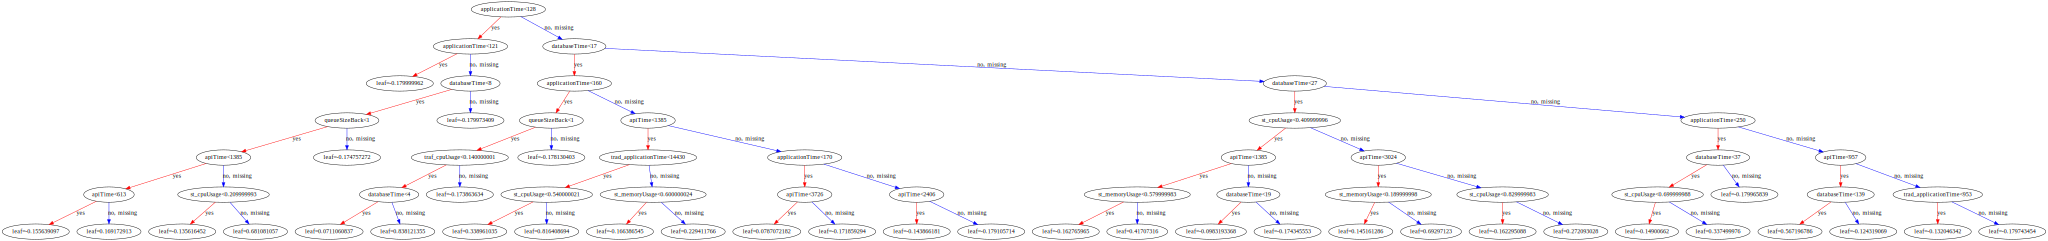

In [20]:
to_graphviz(model, num_trees=0, rankdir='UD')

Confusion matrix of predictions

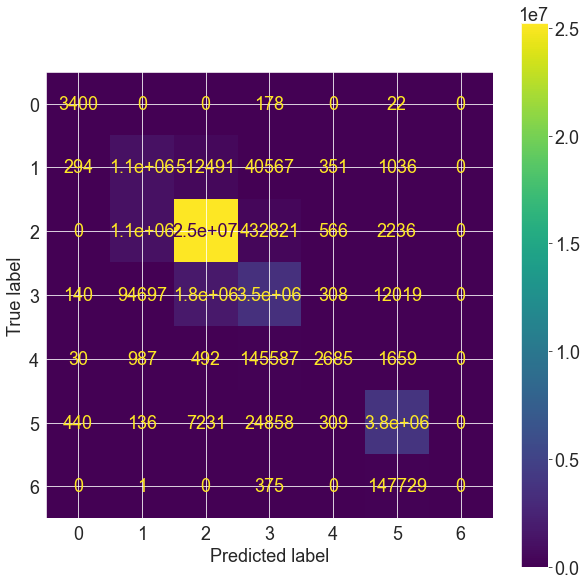

In [22]:

cm = confusion_matrix(Y_test, model_Y_predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax)

plt.rc('font', size=18)
plt.show()